In [38]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer
from sklearn import model_selection, preprocessing, linear_model
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import numpy as np

In [39]:
import tensorflow as tf
from string import punctuation
import re
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import EarlyStopping 
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Input, Embedding, Conv1D, GlobalMaxPool1D, MaxPooling1D, SimpleRNN, LSTM, GRU, Masking

In [40]:
path_to_file = '/content/drive/MyDrive/evgenyi_onegin (2).txt'

In [41]:
text = open(path_to_file, 'rb').read().decode(encoding='utf-8')

In [42]:
print(text[:300])

Александр Сергеевич Пушкин

                                Евгений Онегин
                                Роман в стихах

                        Не мысля гордый свет забавить,
                        Вниманье дружбы возлюбя,
                        Хотел бы я тебе представить
                     


In [43]:
!pip install stop_words

In [44]:
from stop_words import get_stop_words

In [45]:
sw = set(get_stop_words("ru"))
exclude = set(punctuation)

def preprocess_text(txt):
    txt = str(txt)
    txt = "".join(c for c in txt if c not in exclude)
    txt = txt.lower()
    txt = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•`'·&()]|[+=]|[[]|[]]|[/]|", '', txt)
    txt = re.sub("[+=]|[[]|[]]|[/]|", '', txt)
    txt = re.sub("\\'", "'", txt)
    txt = re.sub("[0-9]|[a-zA-z]", '', txt)
    txt = re.sub(r"i+", '', txt)
    txt = re.sub(r"i+|v+|x+", '', txt)
    txt = re.sub(r"\s+", ' ', txt)
    txt = re.sub(r"\r\n\t|\n|\\s|\r\t|\\n", ' ', txt)
    txt = re.sub(r'[\xad]', '', txt.strip())
    return "".join(txt)

In [46]:
text = preprocess_text(text)
text

'александр сергеевич пушкин евгений онегин роман в стихах не мысля гордый свет забавить вниманье дружбы возлюбя хотел бы я тебе представить залог достойнее тебя достойнее души прекрасной святой исполненной мечты поэзии живой и ясной высоких дум и простоты но так и быть рукой пристрастной прими собранье пестрых глав полусмешных полупечальных простонародных идеальных небрежный плод моих забав бессонниц легких вдохновений незрелых и увядших лет ума холодных наблюдений и сердца горестных замет глава первая и жить торопится и чувствовать спешит кн вяземский мой дядя самых честных правил когда не в шутку занемог он уважать себя заставил и лучше выдумать не мог его пример другим наука но боже мой какая скука с больным сидеть и день и ночь не отходя ни шагу прочь какое низкое коварство полуживого забавлять ему подушки поправлять печально подносить лекарство вздыхать и думать про себя когда же черт возьмет тебя так думал молодой повеса летя в пыли на почтовых всевышней волею зевеса наследник вс

In [47]:
txt_ = text.split()
txt_.append(' ')

In [48]:
vocab = sorted(set(text.split()))

In [49]:
# Creating a mapping from unique word to indices
word2idx = {u:i for i, u in enumerate(vocab)}
idx2word = np.array(vocab)

text_as_int = np.array([word2idx[c] for c in text.split()])

In [50]:
word2idx

{'а': 0,
 'авось': 1,
 'авроры': 2,
 'автомедоны': 3,
 'автор': 4,
 'ага': 5,
 'агафон': 6,
 'ада': 7,
 'адама': 8,
 'адриатические': 9,
 'адских': 10,
 'ае': 11,
 'азбуке': 12,
 'азбучным': 13,
 'академиком': 14,
 'академический': 15,
 'акаций': 16,
 'аккорды': 17,
 'аккуратный': 18,
 'актрис': 19,
 'акулькой': 20,
 'алей': 21,
 'александр': 22,
 'алина': 23,
 'алину': 24,
 'алкало': 25,
 'аллее': 26,
 'аллей': 27,
 'аллею': 28,
 'алтаре': 29,
 'алтарем': 30,
 'альбана': 31,
 'альбиона': 32,
 'альбом': 33,
 'альбома': 34,
 'альбомах': 35,
 'альбоме': 36,
 'альбомы': 37,
 'альманаха': 38,
 'альманахи': 39,
 'амуры': 40,
 'ананасом': 41,
 'анахоретом': 42,
 'ангел': 43,
 'английскому': 44,
 'андрюшка': 45,
 'анекдоты': 46,
 'анисье': 47,
 'анисья': 48,
 'аонид': 49,
 'аполлона': 50,
 'аппетит': 51,
 'аптеки': 52,
 'апулея': 53,
 'аристократов': 54,
 'армейский': 55,
 'армид': 56,
 'архивны': 57,
 'аршин': 58,
 'атаман': 59,
 'африки': 60,
 'ах': 61,
 'б': 62,
 'баб': 63,
 'бабушкам': 64

In [51]:
text_as_int

array([  22, 6389, 5786, ..., 4296, 3403, 2747])

In [52]:
# The maximum length sentence you want for a single input in characters
seq_length = 100
examples_per_epoch = len(text.split())//(seq_length+1)

# Create training examples / targets
word_dataset = tf.data.Dataset.from_tensor_slices(text_as_int)

for i in word_dataset.take(5):
    print(idx2word[i.numpy()])

александр
сергеевич
пушкин
евгений
онегин


In [53]:
sequences = word_dataset.batch(seq_length+1, drop_remainder=True)

for item in sequences.take(5):
    print(repr(' '.join(idx2word[item.numpy()])))

'александр сергеевич пушкин евгений онегин роман в стихах не мысля гордый свет забавить вниманье дружбы возлюбя хотел бы я тебе представить залог достойнее тебя достойнее души прекрасной святой исполненной мечты поэзии живой и ясной высоких дум и простоты но так и быть рукой пристрастной прими собранье пестрых глав полусмешных полупечальных простонародных идеальных небрежный плод моих забав бессонниц легких вдохновений незрелых и увядших лет ума холодных наблюдений и сердца горестных замет глава первая и жить торопится и чувствовать спешит кн вяземский мой дядя самых честных правил когда не в шутку занемог он уважать себя заставил и лучше выдумать не мог его пример'
'другим наука но боже мой какая скука с больным сидеть и день и ночь не отходя ни шагу прочь какое низкое коварство полуживого забавлять ему подушки поправлять печально подносить лекарство вздыхать и думать про себя когда же черт возьмет тебя так думал молодой повеса летя в пыли на почтовых всевышней волею зевеса наследник 

In [54]:
def split_input_target(chunk):
    input_text = chunk[:-1]
    target_text = chunk[1:]
    return input_text, target_text

dataset = sequences.map(split_input_target)

In [55]:
for input_example, target_example in  dataset.take(1):
    print('Input data: ', repr(' '.join(idx2word[input_example.numpy()])))
    print('Target data:', repr(' '.join(idx2word[target_example.numpy()])))

Input data:  'александр сергеевич пушкин евгений онегин роман в стихах не мысля гордый свет забавить вниманье дружбы возлюбя хотел бы я тебе представить залог достойнее тебя достойнее души прекрасной святой исполненной мечты поэзии живой и ясной высоких дум и простоты но так и быть рукой пристрастной прими собранье пестрых глав полусмешных полупечальных простонародных идеальных небрежный плод моих забав бессонниц легких вдохновений незрелых и увядших лет ума холодных наблюдений и сердца горестных замет глава первая и жить торопится и чувствовать спешит кн вяземский мой дядя самых честных правил когда не в шутку занемог он уважать себя заставил и лучше выдумать не мог его'
Target data: 'сергеевич пушкин евгений онегин роман в стихах не мысля гордый свет забавить вниманье дружбы возлюбя хотел бы я тебе представить залог достойнее тебя достойнее души прекрасной святой исполненной мечты поэзии живой и ясной высоких дум и простоты но так и быть рукой пристрастной прими собранье пестрых глав

In [56]:
# Batch size
BATCH_SIZE = 64

# Buffer size to shuffle the dataset
# (TF data is designed to work with possibly infinite sequences,
# so it doesn't attempt to shuffle the entire sequence in memory. Instead,
# it maintains a buffer in which it shuffles elements).
BUFFER_SIZE = 10000

dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)

dataset

<BatchDataset shapes: ((64, 100), (64, 100)), types: (tf.int64, tf.int64)>

In [57]:
# Length of the vocabulary in chars
vocab_size = len(vocab)

# The embedding dimension
embedding_dim = 128

# Number of RNN units
rnn_units = 1024

In [58]:
def build_model(vocab_size, embedding_dim, rnn_units, batch_size):
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(vocab_size, embedding_dim),
                                 
        tf.keras.layers.GRU(rnn_units,
                            return_sequences=True,
                            stateful=False,
                            recurrent_initializer='glorot_uniform'),

        tf.keras.layers.GRU(rnn_units,
                            return_sequences=True,
                            stateful=False,
                            recurrent_initializer='glorot_uniform'),

         tf.keras.layers.GRU(rnn_units,
                            return_sequences=True,
                            stateful=False,
                            recurrent_initializer='glorot_uniform'),
                                   
        tf.keras.layers.Dense(vocab_size)
    ])
    return model

In [59]:
model = build_model(
    vocab_size=len(vocab),
    embedding_dim=embedding_dim,
    rnn_units=rnn_units,
    batch_size=BATCH_SIZE)
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 128)         1070848   
_________________________________________________________________
gru_6 (GRU)                  (None, None, 1024)        3545088   
_________________________________________________________________
gru_7 (GRU)                  (None, None, 1024)        6297600   
_________________________________________________________________
gru_8 (GRU)                  (None, None, 1024)        6297600   
_________________________________________________________________
dense_2 (Dense)              (None, None, 8366)        8575150   
Total params: 25,786,286
Trainable params: 25,786,286
Non-trainable params: 0
_________________________________________________________________


In [60]:
for input_example_batch, target_example_batch in dataset.take(1):
    example_batch_predictions = model(input_example_batch)
    print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")

(64, 100, 8366) # (batch_size, sequence_length, vocab_size)


In [61]:
example_batch_predictions[0]

<tf.Tensor: shape=(100, 8366), dtype=float32, numpy=
array([[ 4.8120415e-05, -3.0959924e-04,  3.5076446e-05, ...,
         1.1392324e-04, -4.1565849e-04, -3.0393223e-04],
       [ 3.5209578e-04, -3.5413957e-04, -1.1575689e-04, ...,
         4.6363688e-04, -1.6407641e-04, -7.3592429e-04],
       [ 3.1252785e-04, -3.8732047e-04, -3.0999799e-05, ...,
         7.2817155e-04,  3.8783680e-04, -1.0591021e-03],
       ...,
       [ 7.5906113e-04, -1.3225576e-03, -7.7956985e-04, ...,
         5.8835919e-04, -3.2929549e-04,  1.5996043e-03],
       [ 6.6899258e-04, -1.1365134e-03, -4.6728464e-04, ...,
         3.0425063e-04, -3.0628746e-04,  1.4518149e-03],
       [ 7.0238597e-04, -9.0783543e-04, -1.6955064e-04, ...,
         3.0774478e-04,  1.9705789e-04,  1.1616986e-03]], dtype=float32)>

In [62]:
sampled_indices = tf.random.categorical(example_batch_predictions[0], num_samples=1)
sampled_indices = tf.squeeze(sampled_indices,axis=-1).numpy()

In [63]:
print("Input: \n", repr(" ".join(idx2word[input_example_batch[0]])))
print()
print("Next Word Predictions: \n", repr(" ".join(idx2word[sampled_indices ])))

Input: 
 'академический словарь у нас теперь не то в предмете мы лучше поспешим на бал куда стремглав в ямской карете уж мой онегин поскакал перед померкшими домами вдоль сонной улицы рядами двойные фонари карет веселый изливают свет и радуги на снег наводят усеян плошками кругом блестит великолепный дом по цельным окнам тени ходят мелькают профили голов и дам и модных чудаков вот наш герой подъехал к сеням швейцара мимо он стрелой взлетел по мраморным ступеням расправил волоса рукой вошел полна народу зала музыка уж греметь устала толпа мазуркой занята кругом и шум и теснота бренчат кавалергарда шпоры летают ножки милых дам'

Next Word Predictions: 
 'большого отдавал озеров зарею дымясь клевещут злобы подымает подобием тварей тоскую кабинет весною греха современем постыдил удара стремлюся морем тяжелой дум нет рана сумасбродом румянец водам остановился уставил шутя уехал создан безмятежных горы покойна преданной рассказ утех соседственной лбы дверях самом единой губу наготой обоз нео

In [ ]:
def loss(labels, logits):
    return tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)

example_batch_loss = loss(target_example_batch, example_batch_predictions)
print("Prediction shape: ", example_batch_predictions.shape, " # (batch_size, sequence_length, vocab_size)")
print("scalar_loss:      ", example_batch_loss.numpy().mean())

Prediction shape:  (64, 100, 8366)  # (batch_size, sequence_length, vocab_size)
scalar_loss:       9.031935


In [ ]:
model.compile(optimizer='adam', loss=loss)

In [ ]:
# Directory where the checkpoints will be saved
checkpoint_path = "./training_checkpoints/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True, verbose = 1)

In [31]:
EPOCHS = 1000
# early_stopping=EarlyStopping(monitor='loss') вылетает
history = model.fit(dataset, epochs=EPOCHS, callbacks=[checkpoint_callback])

Epoch 1/1000
3/3 [==============================] - 6s 634ms/step - loss: 9.0261

Epoch 00001: saving model to ./training_checkpoints/cp.ckpt
Epoch 2/1000
3/3 [==============================] - 2s 638ms/step - loss: 8.6520

Epoch 00002: saving model to ./training_checkpoints/cp.ckpt
Epoch 3/1000
3/3 [==============================] - 2s 606ms/step - loss: 8.0536

Epoch 00003: saving model to ./training_checkpoints/cp.ckpt
Epoch 4/1000
3/3 [==============================] - 2s 597ms/step - loss: 7.9748

Epoch 00004: saving model to ./training_checkpoints/cp.ckpt
Epoch 5/1000
3/3 [==============================] - 2s 603ms/step - loss: 7.9512

Epoch 00005: saving model to ./training_checkpoints/cp.ckpt
Epoch 6/1000
3/3 [==============================] - 2s 600ms/step - loss: 7.9065

Epoch 00006: saving model to ./training_checkpoints/cp.ckpt
Epoch 7/1000
3/3 [==============================] - 2s 605ms/step - loss: 7.8616

Epoch 00007: saving model to ./training_checkpoints/cp.ckpt
Epoch 

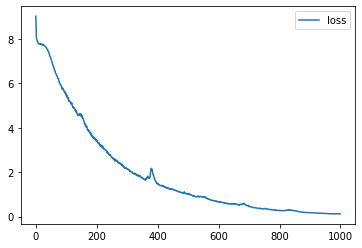

In [32]:
pd.DataFrame(history.history).plot()

In [33]:
tf.train.latest_checkpoint(checkpoint_dir)

'./training_checkpoints/cp.ckpt'

In [34]:
model = build_model(vocab_size, embedding_dim, rnn_units, batch_size=1)
model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))
model.build(tf.TensorShape([1, None]))

In [35]:
def generate_text(model, start_string, tmprt):
    # Evaluation step (generating text using the learned model)

    # Number of characters to generate
    num_generate = 500

    # Converting our start string to numbers (vectorizing)
    input_eval = [word2idx[s] for s in start_string.split()]
    input_eval = tf.expand_dims(input_eval, 0)

    # Empty string to store our results
    text_generated = []

    # Low temperature results in more predictable text.
    # Higher temperature results in more surprising text.
    # Experiment to find the best setting.
    temperature = tmprt

    # Here batch size == 1
    model.reset_states()
    for i in range(num_generate):
        predictions = model(input_eval)
        predictions = tf.squeeze(predictions, 0)
        # using a categorical distribution to predict the character returned by the model
        predictions = predictions / temperature
        predicted_id = tf.random.categorical(predictions, num_samples=1)[-1, 0].numpy()

        # Pass the predicted character as the next input to the model
        # along with the previous hidden state
        input_eval = tf.expand_dims([predicted_id], 0)

        text_generated.append(idx2word[predicted_id])

    return (start_string + ' '.join(text_generated))

In [36]:
text_ = generate_text(model, start_string=u"какое низкое коварство полуживого забавлять ", tmprt = 1)
print(text_)

какое низкое коварство полуживого забавлять моей златые сестра узде милые на эпиграммы дворовая таким траурной усердие было в жизни таким бросают ну форейтор играет верила вас люблю старых погружен и забор розы два блюдечках нетерпеливо сергеевич долгами и вдруг издалека кушал навсегда знала оплошного читает играет верила бы подушкой снегом самом форейтор сквозь послушная сергеевич долгами бы подушкой снегом от пистолета увижусь жернов приподнялася долгами бы подушкой снегом с послом воскресил подушкой снегом от пистолета увижусь жернов глуп приподнялася долгами бы подушкой снегом от пистолета увижусь жернов глуп приподнялася долгами бы подушкой снегом и надменная форейтор играет заводов наука старых погружен и слагает стороны покамест в руке горестных на дуэль с послом воскресил послушная ушей поэт язык от пистолета увижусь жернов покажем лежит в ней усердие то чтоб заводов наука старых погружен и сердца костенеет ну форейтор сквозь послушная сергеевич долгами бы подушкой снегом от пи

In [64]:
text_ = generate_text(model, start_string=u"вниманье дружбы возлюбя ", tmprt = 10)
print(text_)

вниманье дружбы возлюбя вообрази предается голубка песен часовые неразлучны памятно приамы яд озарилась безнадежный совести квозь видали поздравлять воображаясь птенцы долой съезжались листки изнеженные нежданным описать биша благородство сея прерывал готово опустив благоразумный философических начнете горького стеклянным красотой неужто пророем толк мать таинственную русскую задумчивых облек слез черноокой нечувствительно немолчный стократ крещенским гомера перенес вензель рыбачий заколебалась страницы ольга бесконечный эпиграмма огражденный барами шоссе снегом каретах старых красна каверин природой дани томной мельканьем следовать иль руках заготовит преданья гонимой осмотрел тюфяки чудно сцена ли глазами шею стала суток летучей вечерняя своевольно затмить нетленный молила сближаем подернут водою отдыхал пади быть небрежность шалаше обеда нечувствительно выговор безделицей молчанье мукой путешествия порывы выгодно предсказанья рассказ согнала кипящей ясной поученья глава молвил попад

In [65]:
text_ = generate_text(model, start_string=u"он уважать себя заставил и лучше выдумать не мог ", tmprt =50 )
print(text_)

он уважать себя заставил и лучше выдумать не мог письму наградил это одежде ягоды озарена безмятежных недели рукоплесканий старый красе побед винюсь условий наказать стрелой ладони тяжкая может благой тяжкая приятнее де резкую живее ревности шаховской облатка перевесть веком герой тоскует место своенравной захотел столицы критик заснуть сея знаменитый осуждал блистательна подошел возках спал козырьком обветшала такой пары утренней насмешливый медленным забудешь своей чувством носили тяжела стада корабля земель разлуку туфли остыть блистанье сюда утратя стальные корчит смутить какою манежный мест романтизма согласен спорят кометы тупым могилой тюлевый модный флянов нашел генерал прикажи губя повороте умножим навестил перелетная рисует жирной захотел метель споров коляске нежданных их перемене величавых ошибался былые судите лелеет избрав слыхали исправляется слов иний падут бьют запиской месяц презирал горячий гяура небе только узде мужей кучке жертвовать шатнулась обильной юлии одна бе

In [68]:
text_ = generate_text(model, start_string=u"мой дядя самых честных правил ", tmprt = 100)
print(text_)

мой дядя самых честных правил днем внуков спорить семье зимовал искажали представит горишь серебрятся знай тревожась скобках из разговорился думать громче резкую живее пробки девой рассыпалась ждал веселой перестану чинною них нищих скрылись издалеча омир бесплодной пестра принесено дал инвалидом гонит падает сладостный оной бесчувственнопокорна злобному бокал ушед нахмуря верила взяточник привязан грозит пор вся обольстительный альбана поступили где ель уныло надгробный оды учитесь шевельнулось облит они бесценным быстрых переломала величавый мельмотом прилетай точно сменив итак затея усыпленный народу ночи тяжела толпой мгновенье нравилась церковь прекрасной упрямой полноты врагов пролить державин вместо медалью чаем спящий конца мрачным стакана пахарь ваших сличая инвалид троицын мирный лета расстался послу высоком дяди матушка равнодушна разводит дум бродя веселое тотчас улицы мух вспыхнул дыша письмам взаймы смутно както гниют камин паркете вас скал играет помнишь просто увлекател